In [1]:
import numpy as np
import scipy.optimize as opt

from openptv_python.calibration import Calibration
from openptv_python.imgcoord import image_coordinates
from openptv_python.orientation import (
    external_calibration,
    full_calibration
)
from openptv_python.parameters import ControlPar, OrientPar, read_control_par, read_target_par
from openptv_python.tracking_frame_buf import Target
from openptv_python.trafo import arr_metric_to_pixel
from openptv_python.imgcoord import img_coord
from openptv_python.trafo import pixel_to_metric
from openptv_python.tracking_frame_buf import Target

from pathlib import Path


In [2]:

import matplotlib.pyplot as plt
%matplotlib widget


In [3]:

from skimage.io import imread


In [4]:
# working directory
work_dir = Path('/home/user/Downloads/For_Alex_test_34')
par_dir = work_dir / "parameters"
cal_dir = work_dir / "cal"
res_dir = work_dir / "res"

In [5]:
control_file_name = par_dir / "ptv.par"
target_parameters_file_name = par_dir / "targ_rec.par"
# self.control = ControlPar(4)
control = read_control_par(control_file_name)
print(control)


ControlPar(num_cams=4, img_base_name=['cal/cam1a.tif', 'cal/cam2a.tif', 'cal/cam3a.tif', 'cal/cam4.tif'], cal_img_base_name=['cal/cam1.tif', 'cal/cam2.tif', 'cal/cam3.tif', 'cal/cam4.tif'], hp_flag=0, all_cam_flag=0, tiff_flag=1, imx=1920, imy=1080, pix_x=0.01, pix_y=0.01, chfield=0, mm=MultimediaPar(nlay=1, n1=1.0, n2=[1.5], d=[1.5], n3=1.33))


In [6]:
orient_par_file_name = par_dir / "orient.par"
orient_par = OrientPar().from_file(orient_par_file_name)

cal = Calibration().from_file(
    cal_dir / "cam1.tif.ori",
    cal_dir / "cam1.tif.addpar",
)
orig_cal = Calibration().from_file(
    cal_dir / "cam1.tif.ori",
    cal_dir / "cam1.tif.addpar",
)

NameError: name 'pathlib' is not defined

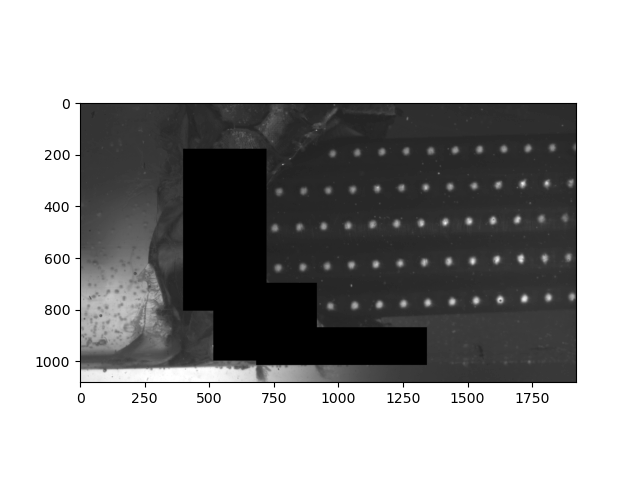

In [ ]:
img = imread(cal_dir / "cam1.tif")
img = img[:,:,0].squeeze()
plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
# detect dots
from openptv_python.segmentation import target_recognition
tpar = read_target_par(target_parameters_file_name)
tpar.gvthresh[0] = 130
cal_images=[img]

detections = []
for img in cal_images:
    target_array = target_recognition(img, tpar, 0, control)
    target_array.sort(key=lambda t: t.y)
    detections.append(target_array)
    
x = [[_.x for _ in cam] for cam in detections]
y = [[_.y for _ in cam] for cam in detections]


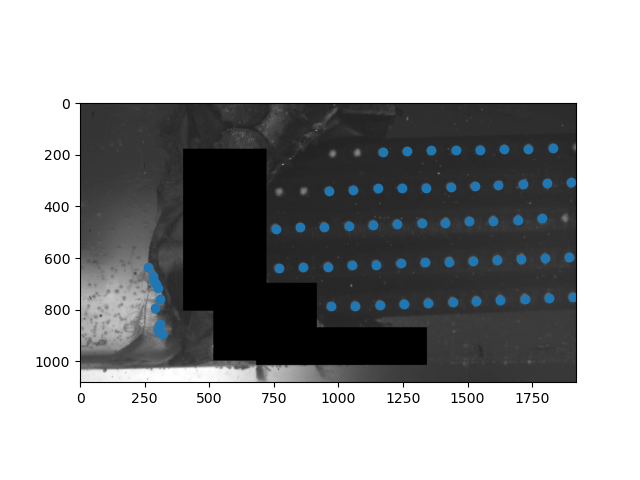

In [ ]:
plt.figure()
plt.imshow(img, cmap='gray')
plt.scatter(x,y)
plt.show()

In [ ]:
ref_pts = np.array(
    [
        [-40.0, -25.0, 8.0],
        [40.0, -15.0, 0.0],
        [40.0, 15.0, 0.0],
        [40.0, 0.0, 8.0],
    ]
)

# Fake the image points by back-projection
targets = arr_metric_to_pixel(
    image_coordinates(ref_pts, cal, control.mm),
    control,
)

cal.set_pos(np.array([0, 0, 100]))
cal.set_angles(np.array([0, 0, 0]))

# Jigg the fake detections to give raw_orient some challenge.
targets[:, 1] -= 0.1

In [ ]:
targs = [Target() for _ in targets]

for ptx, pt in enumerate(targets):
    targs[ptx].x = pt[0]
    targs[ptx].y = pt[1]

In [ ]:
# def residual(calibration_array, ref_pts, targs, control, cc):
#     # print(calibration_array)
#     # print(ref_pts)
#     # print(targs)
#     # print(control)
#     # print(calibration_array)
    
#     c = Calibration()
#     c.set_pos(calibration_array[:3])
#     c.set_angles(calibration_array[3:])
#     c.int_par.cc = cc
#     c.update_rotation_matrix()
    
    
#     # print(f"{c.get_pos()=}")
                
#     residual = 0
#     for i in range(len(targs)):
#         xc, yc = pixel_to_metric(targs[i].x, targs[i].y, control)
#         # print(f"{xc=}, {yc=} mm")
        
#         xp, yp = img_coord(ref_pts[i], c, control.mm)
#         # print(f"{xp=}, {yp=} mm")
#         residual += ((xc - xp)**2 + (yc - yp)**2)
        
#         # print(f"{residual=}")
        
#     return residual

In [ ]:
# x0 = np.hstack([cal.get_pos(), cal.get_angles()])
# cc = orig_cal.int_par.cc

# sol = opt.minimize(residual, x0, args=(ref_pts, targs, control, cc), method='Nelder-Mead', tol=1e-6)

In [ ]:
# print( residual(np.hstack([orig_cal.get_pos(), orig_cal.get_angles()]), ref_pts, targs, control, orig_cal.int_par.cc))

In [ ]:
import copy
def added_par_residual(added_par_array, ref_pts, targs, control, cal):
    # print(calibration_array)
    # print(ref_pts)
    # print(targs)
    # print(control)
    # print(calibration_array)
    c = copy.deepcopy(cal)
    c.added_par = added_par_array
    
    # print(f"{c.get_pos()=}")
                
    residual = 0
    for i in range(len(targs)):
        xc, yc = pixel_to_metric(targs[i].x, targs[i].y, control)
        # print(f"{xc=}, {yc=} mm")
        
        xp, yp = img_coord(ref_pts[i], c, control.mm)
        # print(f"{xp=}, {yp=} mm")
        residual += ((xc - xp)**2 + (yc - yp)**2)
        
        # print(f"{residual=}")
        
    return residual

In [ ]:
x0 = np.array(cal.added_par.tolist())

sol = opt.minimize(added_par_residual, x0, args=(ref_pts, targs, control, cal), method='Nelder-Mead', tol=1e-6)
print(f"{sol.x=}")
# print(sol.x - np.hstack([orig_cal.get_pos(), orig_cal.get_angles()]))



sol.x=array([ 1.88429794e-03, -2.64096734e-06,  7.86931927e-10, -4.99466854e-04,
       -9.47266082e-04,  8.91507002e-01,  1.34638641e-04])


In [ ]:
# print(sol.x)
print(cal.added_par)
cal.set_added_par(sol.x)
print(cal.added_par)
full_calibration(cal, ref_pts, targets, control, orient_par)
print(cal.added_par)

[0. 0. 0. 0. 0. 1. 0.]
[ 1.88429794e-03 -2.64096734e-06  7.86931927e-10 -4.99466854e-04
 -9.47266082e-04  8.91507002e-01  1.34638641e-04]
[ 1.88429794e-03 -2.64096734e-06  7.86931927e-10 -4.99466854e-04
 -9.47266082e-04  8.91507002e-01  1.34638641e-04]


In [ ]:
print(cal.get_pos())
print(cal.get_angles())
print(cal.get_primary_point())
print(cal.get_decentering())
print(cal.added_par)

[-69.23929405 -28.80270812  44.35239053]
[ 0.27807446 -0.77988742  0.35998933]
[-4.e-04 -2.e-04  9.e+01]
[-0.00049947 -0.00094727]
[ 1.88429794e-03 -2.64096734e-06  7.86931927e-10 -4.99466854e-04
 -9.47266082e-04  8.91507002e-01  1.34638641e-04]
